--------------------------------------------------------------------------------------

* Team member names: Elsie Wang, Hou Wan

* Team member IDs: A16655032, A16462095

--------------------------------------------------------------------------------------

# Optimizing Camping Spots with OpenAI and ArcGIS

## Introduction

Our project aims to identify optimal camping spots based using OpenAI to get user preferences such as stargazing quality, amenities, proximity to recreational activities, specifically in San Diego County. This question is important as it addresses the growing interest in outdoor activities while considering environmental sustainability and accessibility. We hypothesize that by combining spatial data analysis with natural language processing, we can create a more intuitive and user-friendly interface for campers to find their ideal locations. The target audience for our project includes outdoor enthusiasts, camping planners, and environmental agencies. By providing a tool that identifies optimal camping locations based on specific criteria, we can enhance the camping experience, promote responsible land use, and potentially contribute to the conservation of natural areas.

We will be taking the following features: light pollution, proximity to trails, proximity to rivers, development of campsite, whether it is a horse campsite, showers, restrooms, RV parking, Vehicle Parking, and boat parking.

### Related Work

The study by Benfield et al. emphasizes the psychological effects of light pollution in natural settings, suggesting that the ambience of camping sites, particularly the level of natural darkness, can significantly influence visitor satisfaction and well-being. This insight is crucial for a campsite recommendation system, highlighting the need to factor in environmental qualities like light pollution when suggesting sites to users, ensuring their outdoor experiences align with their psychological preferences for natural or ambient lighting conditions【Benfield et al.】.

In their research, Beeco and Brown discuss the integration of spatial tools and analysis in outdoor recreation, advocating for the use of spatially-related social science data in park management. This approach can improve campsite recommendations by incorporating data on user distribution, site attributes, and environmental factors, thereby optimizing the spatial arrangement of campsites for enhanced user experiences【Beeco and Brown】.

The GeoGPT+ framework, developed by Zhang et al., showcases how language models can be adapted to interpret and execute geospatial tasks based on natural language inputs. This innovation makes GIS analyses more accessible to non-experts and can be effectively applied in a campsite recommendation system to process user preferences and perform complex spatial analyses to identify ideal camping locations【Zhang et al., 2023】.

Lastly, the research by Cuirong et al. on campground suitability in Kuerdening, China, provides a methodological example of using GIS and multiple criteria decision analysis to assess potential campsite locations. This study demonstrates how environmental and infrastructural factors can be systematically evaluated to determine the most suitable camping areas, offering a structured approach that can be adapted for campsite recommendation systems【Cuirong et al., 2016】.

### Python Packages

The ArcGIS package serves as a comprehensive toolkit for GIS operations, essential for integrating geographic information into your campsite recommendation system. Modules like arcgis.raster and arcgis.geocoding allow for handling raster data and converting addresses to coordinates, crucial for analyzing environmental factors such as light/air pollution and locating campsites. Classes such as GeoAccessor and use_proximity from arcgis.features enable spatial operations on data frames and proximity analysis, enhancing the system's ability to recommend campsites based on user-defined criteria such as proximity to trails and rivers. Integrating openai adds natural language processing, making user interactions more intuitive by allowing campsite preferences to be expressed and understood in natural language, as well allowing natural language to be processed into GIS operations. This list has not evolved compared to our initial project proposal.

### References

**Data**

We sourced a diverse array of datasets to ensure a comprehensive analysis of environmental and infrastructural factors relevant to campsite suitability. The datasets we selected are as follows:

California State Parks (https://www.parks.ca.gov/?page_id=29682): This dataset provides extensive information on park boundaries, campgrounds, and facilities within California's state parks. However, it lacks data on national parks, which might limit the breadth of our recommendations.

River Features (https://hub.arcgis.com/datasets/de8d118c32da4a22a091848458e761fd_0/explore): Essential for evaluating water body proximity to campsites, this dataset's accuracy in river paths and buffer zones is critical for precise campsite recommendations.

Light Pollution (https://ic.img.arcgis.com/arcgis/rest/services/VIIRS/NighttimeLightsMDNB/ImageServer): Light pollution levels, sourced from raster imagery, are crucial for assessing potential stargazing quality at campsites, with the dataset's resolution being a key factor for precise recommendations as it is an imagery layer.

Air Pollution (https://sedac.ciesin.columbia.edu/arcgis/rest/services/sedac/sdei_global_annual_avg_pm2_5_2001_2010_image_service/ImageServer): Air quality data is vital for ensuring the health and comfort of campsite users. The timeliness and source credibility of this data are essential for its reliability in my analysis.

Since the initial proposal, we've expanded the scope of our data sources to include qualitative environmental factors such as air pollution, enhancing the overall campsite evaluation process. However, we've encountered challenges related to data recency, resolution, and access limitations. For instance, the imagery layers utilized are too high, and takes a lot of processing time to convert to feature sets. Imports of the data can be seen in the next section.

**Other References**

Jacob A. Benfield, Robert J. Nutt, B. Derrick Taff, Zachary D. Miller, Heather Costigan, Peter Newman, A laboratory study of the psychological impact of light pollution in national parks

J. Adam Beeco, Greg Brown, Integrating space, spatial tools, and spatial analysis into the human dimensions of parks and outdoor recreation

https://arxiv.org/abs/2307.07930 GeoGPT+
GeoGPT is a layer on top of 

https://www.degruyter.com/document/doi/10.1515/geo-2016-0028/html GIS for campsite suitability

--------------------------------------------------------------------------------------

In [1]:
# Import statements, etc.
import warnings
warnings.filterwarnings("ignore")

from json import load
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy.stats as stats
from openai import OpenAI
import json
from json import load

import arcgis
from arcgis.gis import GIS
from arcgis.raster.functions import *
from ipywidgets import *
from IPython.display import display
from arcgis.geocoding import geocode
from arcgis.geometry import *
from arcgis.features import GeoAccessor
from arcgis.features import use_proximity
from shapely.geometry import box
from arcgis.features import FeatureLayer

# Used with github repo load login information for GIS
LOGIN = load(open('./login.json', 'r'))
gis = GIS(username=LOGIN['username'], password=LOGIN['password'], expiration=9999)

# Used with github repo load OpenAI key
KEY = load(open('./key.json', 'r'))
client = OpenAI(api_key=KEY['OpenAIKey'])

## Data Cleaning

The amount of cleaning/data preparation was similar to what we expected in the project proposal. To establish a campground dataset with all the features, it was expected that we would combine a lot of geodataframes from different shapefiles.

For our campgrounds dataframe, we merged the buildings associated with the campground and parking that was offered. Within the building dataframe itself contained a lot of information regarding amentites, such as restrooms and showers. Since all three came from the same source, merging them by the campground name would be smoother. Thus, we cleaned both dataframes and aggregated them to the campground dataset with boolean columns to make filtering campgrounds easier later on.


Additionally, we acquired routes and fitered it to only public routes, buffering it by 1000 meters. For rivers, we gave a buffer of 3000 meters. Whether campsites were within these buffers was also added to the campground dataset for easier filter campgrounds later on.

For the raster data, we clipped and gave an extent to only San Diego County for the light pollution and air polllution imagery layers. We also normalized the values to 9 bins with scores from 1-9, 9 being the most suitable for camping and 1 being the worst. Doing this first would allow us to dynamically perform suitability analysis on different weights.

### Load Datasets

In [2]:
data_location = os.environ["HOME"] + '/dsc170_finalproject_camping/data/'

In [3]:
# Load in shapefile
campgrounds = gpd.read_file(data_location + 'campgrounds/Campgrounds.shp')
buildings = gpd.read_file(data_location + 'buildings/Buildings.shp')
parking = gpd.read_file(data_location + 'parking/ParkingPoints.shp')
routes = gpd.read_file(data_location + 'routes/RecreationalRoutes.shp')
river = gpd.read_file(data_location + 'river/748e59dc-3bbc-4f48-a111-49be3925f2342020328-1-14slxpm.r36t.shp')

# Load in imagery layers
light_pollution = ImageryLayer('https://ic.img.arcgis.com/arcgis/rest/services/VIIRS/NighttimeLightsMDNB/ImageServer',gis)
air_pollution = ImageryLayer('https://sedac.ciesin.columbia.edu/arcgis/rest/services/sedac/sdei_global_annual_avg_pm2_5_2001_2010_image_service/ImageServer', gis)

### Descriptive Statistics

For our project, we are not using descriptive statistics due to the dynamic nature of our project and the lack of analysis required. Rather, we are leveraging this data to find the best campgrounds for a user. However, based on observations from mapping, we observe some interesting statistics. Namely, how much data is involved in the light pollution layer and how drastically the campgrounds dataset reduced when we filtered it only to San Diego County campgrounds. Additionally, a lof of information is missing in the campground dataset and adjacent datasets, prompting us to remove rows with certain NaN values. For the datasets, it seems that Developed campsites were the most common among many types of campsites while Vehicle parking was the most common for parking offered.

In [4]:
# Derive the area of interest (AOI) and its geometry and extent for San Diego County

counties_item = gis.content.search('USA Counties generalized', 'Feature Layer', outside_org=True)[5]
counties_lyr = counties_item.layers[0]
study_area_query = counties_lyr.query("FIPS='06073'", return_geometry=True)

#Extract input data for study area
study_area_geom = study_area_query.features[0].geometry
study_area_geom['spatialReference'] = study_area_query.spatial_reference

# Create extent dict
study_area_ex = Geometry(study_area_geom).geoextent
tup = (('xmin',study_area_ex[0]), ('ymin', study_area_ex[1]), ('xmax',study_area_ex[2]), ('ymax', study_area_ex[3]))
study_area_extent = dict(tup)

#Create bbox
bbox = box(study_area_ex[0], study_area_ex[1], study_area_ex[2], study_area_ex[3])

# Add crs
crs = "{'latestwkid':3857, 'wkid':102100}"
study_area_extent.update({'spatialReference':{'latestwkid':3857, 'wkid':102100}})
study_area_extent

{'xmin': -13090875.0407958,
 'ymin': 3833847.56313313,
 'xmax': -12922139.2950188,
 'ymax': 3963248.36768519,
 'spatialReference': {'latestwkid': 3857, 'wkid': 102100}}

In [5]:
# Create a function to clip and set study area extent
def extent_clip(feature):
    feature.extent = study_area_extent
    features_clip = clip(raster=feature, geometry=study_area_geom)
    return features_clip

In [6]:
# Define colormap
clrmap9 =  [[9, 230, 0, 0], [8, 242, 85, 0], [7, 250, 142, 0], [6, 255, 195, 0], [5, 255, 255, 0], [4, 197, 219, 0],  
          [3, 139, 181, 0], [2, 86, 148, 0], [1, 38, 115, 0]]

#### Buildings

In [7]:
# Filter out NaN values
buildings = buildings[buildings['TYPE'].notna()]

# Filter rows and create columns for if restroom or shower
restrooms = ['Chemical toilet', 
             'Combo building', 
             'Comfort station', 
             'Comfort station/dressing room', 
             'Flush toilet', 
             'Unisex combination building', 
             'Unisex comfort station', 
             'Vault toilet']
showers = ['Bath house', 
           'Combo building', 
           'Shower building', 
           'Unisex combination building']
buildings= buildings[buildings['TYPE'].isin(restrooms + showers)]
buildings['Restrooms'] = buildings['TYPE'].isin(restrooms)
buildings['Showers'] = buildings['TYPE'].isin(showers)
buildings['Flush_toilet'] = buildings['TYPE'] == 'Flush toilet'

# Group by campground
def any_true(x):
    '''Returns true if any values in series is true'''
    return x.any()
grouped_buildings = buildings.groupby('UNITNAME').agg({'Restrooms': any_true, 
                                                       'Showers': any_true, 
                                                       'Flush_toilet': any_true})
grouped_buildings.head()

,Restrooms,Showers,Flush_toilet
UNITNAME,,,
Admiral William Standley SRA,True,False,False
Angel Island SP,True,True,False
Antelope Valley California Poppy Preserve (SNR),True,False,False
Anza-Borrego Desert SP,True,False,False
Armstrong Redwoods SNR,True,True,False


#### Parking

In [8]:
parking['SUBTYPE'].value_counts()

Vehicle            2108
Administrative      114
Boat                 47
Equestrian           26
RV/Bus/Trailer       21
Campground Spur       2
Name: SUBTYPE, dtype: int64

In [9]:
parking['RV Parking'] = parking['SUBTYPE'] == 'RV/Bus/Trailer'
parking['Vehicle Parking'] = parking['SUBTYPE'] == 'Vehicle'
parking['Boat Parking'] = parking['SUBTYPE'] == 'Boat'

grouped_parking = parking.groupby('UNITNAME').agg({'RV Parking': any_true, 
                                                       'Vehicle Parking': any_true, 
                                                       'Boat Parking': any_true})
grouped_parking.head()

,RV Parking,Vehicle Parking,Boat Parking
UNITNAME,,,
Ahjumawi Lava Springs SP,False,True,False
Anderson Marsh SHP,False,True,False
Andrew Molera SP,False,True,False
Angel Island SP,False,True,False
Antelope Valley California Poppy Preserve (SNR),True,True,False


#### Campgrounds

In [10]:
campgrounds['TYPE'].value_counts()

Developed Family Camp Area    198
Developed Group Camp Area      82
Primitive Family Camp Area     78
Environmental Camp Area        54
Hike/Bike Camp Area            40
Undefined                      25
Horse Camp Area                18
Primitive Group Camp Area      17
Enroute Camp Area               8
Walk-in Camp Area               1
Name: TYPE, dtype: int64

In [11]:
# Filter na values
campgrounds = campgrounds[campgrounds['TYPE'].notna()]
campgrounds = campgrounds[campgrounds['DETAIL'] != 'Proposed']

# Create columns for different types of camping
campgrounds['Primitive'] = campgrounds['TYPE'].str.contains('Primitive')
campgrounds['Developed'] = campgrounds['TYPE'].str.contains('Developed')
campgrounds['Horse'] = campgrounds['TYPE'] == 'Horse Camp Area'

campgrounds_merged = campgrounds.merge(grouped_buildings, on='UNITNAME', how='left')
campgrounds_merged = campgrounds_merged.merge(grouped_parking, on='UNITNAME', how='left')
campgrounds_merged.head()

,FID,Campground,GISID,TYPE,SUBTYPE,UNITNBR,DETAIL,UNITNAME,SHARE,GlobalID,...,geometry,Primitive,Developed,Horse,Restrooms,Showers,Flush_toilet,RV Parking,Vehicle Parking,Boat Parking
0,2074,Ritchey Creek Campground,GIS0006395,Developed Family Camp Area,None,240,Ritchey Creek Campground,Bothe-Napa Valley SP,None,{AC98673D-5387-4783-BB72-ED2987FA86AE},...,POINT (-13639496.195 4657348.494),False,True,False,True,True,False,False,True,False
1,2075,Bothe-Napa Valley Group Camp,GIS0006396,Developed Group Camp Area,None,240,Bothe-Napa Valley Group Camp,Bothe-Napa Valley SP,None,{196BF388-E240-49EC-A361-4330849D07E8},...,POINT (-13638520.925 4657386.784),False,True,False,True,True,False,False,True,False
2,2076,Brannan Island Group Camp,GIS0006398,Developed Group Camp Area,None,314,Brannan Island Group Camp,Brannan Island SRA,None,{D089D94A-75A3-409E-8B95-613D918F27C5},...,POINT (-13546051.275 4596380.365),False,True,False,True,True,False,False,True,True
3,2077,Walk-in Campsites,GIS0006399,Developed Family Camp Area,None,314,Walk-in Campsites,Brannan Island SRA,None,{C880DECC-2000-48C3-953E-B6AD4C29B49C},...,POINT (-13546394.584 4595659.599),False,True,False,True,True,False,False,True,True
4,2078,North Grove Campground,GIS0006400,Developed Family Camp Area,None,306,North Grove Campground,Calaveras Big Trees SP,None,{3C9F0EA0-DB71-479E-9486-C45DDB6C579E},...,POINT (-13392613.832 4618511.183),False,True,False,True,True,False,False,True,False


In [12]:
# Filter to only campgrounds in SD County
sd_campgrounds = campgrounds_merged[campgrounds_merged.geometry.within(bbox)]
sd_campgrounds

,FID,Campground,GISID,TYPE,SUBTYPE,UNITNBR,DETAIL,UNITNAME,SHARE,GlobalID,...,geometry,Primitive,Developed,Horse,Restrooms,Showers,Flush_toilet,RV Parking,Vehicle Parking,Boat Parking
17,2091,San Mateo Campground,GIS0006413,Developed Family Camp Area,None,663,"San Mateo Campground, 67 with hookups",San Onofre SB,None,{26CEEA10-9E0E-493D-A30B-EE5042F5B0E2},...,POINT (-13089426.405 3949477.589),False,True,False,True,True,False,True,True,False
34,2108,Doane Valley Campground,GIS0006431,Developed Family Camp Area,None,617,Doane Valley Campground,Palomar Mountain SP,None,{F6642198-509A-4C53-A45B-F3F82F9C6E46},...,POINT (-13013420.574 3940970.182),False,True,False,True,True,False,False,True,False
50,2124,San Elijo Campground,GIS0006453,Developed Family Camp Area,None,654,San Elijo Campground,San Elijo SB,None,{25A3CD2D-ED84-490F-9E03-06552E3CE9FD},...,POINT (-13056041.578 3898103.510),False,True,False,True,True,False,False,True,False
51,2125,South Carlsbad Campground,GIS0006454,Developed Family Camp Area,None,652,South Carlsbad Campground,South Carlsbad SB,None,{DF6FA8AD-CE04-426C-BF3D-B86BD0B5D53B},...,POINT (-13059851.822 3908796.512),False,True,False,True,True,False,False,True,False
70,2144,Silver Strand Campground,GIS0006476,Developed Family Camp Area,None,614,RV Parking Lot Campground,Silver Strand SB,None,{AE6C73F4-09F4-4074-8249-60B7F5142BB3},...,POINT (-13040254.471 3847011.054),False,True,False,True,True,False,True,True,False
99,2173,Borrego Palm Canyon Campground,GIS0006509,Developed Family Camp Area,None,622,Borrego Palm Canyon Hookups,Anza-Borrego Desert SP,None,{DBD53A7F-58E1-41C4-AE61-408B9FFB59B0},...,POINT (-12958483.737 3931119.541),False,True,False,True,False,False,False,True,False
100,2174,Borrego Palm Canyon Group Camp,GIS0006510,Developed Group Camp Area,None,622,Borrego Palm Canyon Group Camp,Anza-Borrego Desert SP,None,{945CFE18-F615-4286-918D-D1F89DA3FFC4},...,POINT (-12959298.707 3930915.038),False,True,False,True,False,False,False,True,False
101,2175,Vern Whitaker Horse Camp,GIS0006511,Horse Camp Area,None,622,None,Anza-Borrego Desert SP,None,{40CA2332-78D6-4B18-BD02-0BF30B2CF281},...,POINT (-12957494.997 3941713.631),False,False,True,True,False,False,False,True,False
102,2176,Tamarisk Grove Campground,GIS0006512,Developed Family Camp Area,None,622,Tamarisk Grove Campground,Anza-Borrego Desert SP,None,{EA55C45D-FFB5-4CB6-89B0-36839E9A899A},...,POINT (-12954893.572 3913636.045),False,True,False,True,False,False,False,True,False
228,2302,Cedar Grove Group Camp,GIS0006648,Developed Group Camp Area,None,617,None,Palomar Mountain SP,None,{7A7600F6-0552-4B97-8A20-65BDEEAF33F4},...,POINT (-13014498.369 3940517.659),False,True,False,True,True,False,False,True,False


In [13]:
# Upload as feature layer
campgrounds_sdf = GeoAccessor.from_geodataframe(sd_campgrounds, inplace=False, column_name='SHAPE')
# campgrounds_fl = campgrounds_sdf.spatial.to_featurelayer(title='CA State Campgrounds in SD County',
#                                                           gis=gis,
#                                                           tags='Camping')

# Get feature layer
campgrounds_fl = gis.content.get('106ef42981894fc09ec0ab54f9a7ec1d')
campgrounds_fl

<Item title:"CA State Campgrounds in SD County" type:Feature Layer Collection owner:dsc170wi24_44>

In [14]:
camp_map = gis.map()
camp_map.extent = study_area_extent  
camp_map.add_layer(campgrounds_fl)
camp_map

MapView(layout=Layout(height='400px', width='100%'))

#### Recreational Routes

In [15]:
routes = routes[routes['SHARE'] == 'Public']
routes.head()

,FID,ROUTENAME,GISID,ROUTECLASS,UNITNBR,UNITNAME,ROUTECAT,ROUTETYPE,SEGLNGTH,SHARE,Shape_Leng,GlobalID,SHAPE_Le_1,geometry
72,23311,LAP,GIS0075760,State Park Road,521,Hungry Valley SVRA,Primitive Rd,Native Material,1100.0,Public,407.877932,{17C364FB-E0F6-43A8-8A82-B50C262D6F41},407.877932,"LINESTRING Z (-13226060.142 4131594.839 0.000,..."
421,23660,Lava Springs Trail,GIS0128939,State Park Trail,190,Ahjumawi Lava Springs SP,None,Native Material,9047.0,Public,2552.327716,{DD5C3862-F726-440D-AF67-07CB6CFA5F9E},2552.327716,"LINESTRING Z (-13520639.129 5028652.868 0.000,..."
425,23664,Nightmare Gulch,GIS0070250,State Park Road,577,Red Rock Canyon SP,Primitive Rd,Native Material,852.0,Public,1274.654037,{44DB3AF1-7AB9-4489-BA86-00202D1AF012},1274.654037,"LINESTRING Z (-13129998.876 4216458.724 0.000,..."
426,23665,Nightmare Gulch turn around area,GIS0070251,State Park Road,577,Red Rock Canyon SP,Primitive Rd,Native Material,258.0,Public,92.928927,{8B563CED-2C5F-4AF7-8313-24E90838660E},92.928927,"LINESTRING Z (-13131843.769 4215224.907 0.000,..."
428,23667,Last Chance Canyon Rd,GIS0070263,State Park Road,577,Red Rock Canyon SP,Primitive Rd,Native Material,853.0,Public,5825.074481,{21B0EF1B-E76F-463A-B791-4A4657B35E8F},5825.074481,"LINESTRING Z (-13127171.707 4218337.212 0.000,..."


<Item title:"State Park Trails" type:Feature Layer Collection owner:dsc170wi24_44>
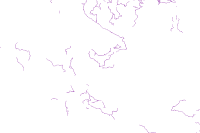

In [16]:
# # Upload as feature layer
# routes_sdf = GeoAccessor.from_geodataframe(routes, inplace=False, column_name='SHAPE')
# routes_fl = routes_sdf.spatial.to_featurelayer(title='State Park Trails',
#                                                          gis=gis,
#                                                          tags='Camping')

#Get feature layer
routes_fl = gis.content.get('a789dc2099c24e659c5829cab5beac2c')
routes_fl

In [17]:
# Create buffers of 1000 meters (0.62 miles)
routes_buffered = use_proximity.create_buffers(routes_fl, distances=[1000], units = 'Meters')

{"cost": 6.478}


In [18]:
routes_map = gis.map()
routes_map.extent = study_area_extent
routes_map.add_layer(routes_buffered)
routes_map.add_layer(routes_fl)
routes_map.add_layer(campgrounds_fl)
routes_map

MapView(layout=Layout(height='400px', width='100%'))

#### Near River

<Item title:"CA Rivers" type:Feature Layer Collection owner:dsc170wi24_44>
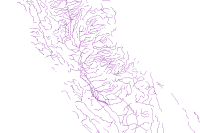

In [19]:
# river_sdf = GeoAccessor.from_geodataframe(river, inplace=False, column_name='SHAPE')
# river_fl = river_sdf.spatial.to_featurelayer(title='CA Rivers',
#                                                          gis=gis,
#                                                          tags='Camping')
river_fl = gis.content.get('d1dc945e8357493cb9219ed3491867fe')
river_fl

In [20]:
# Create buffers of 3000 meters (1.89 miles)
rivers_buffered = use_proximity.create_buffers(river_fl, distances=[3000], units = 'Meters')

{"cost": 1.171}


In [21]:
river_map = gis.map('California, US')
river_map.add_layer(campgrounds_fl)
river_map.add_layer(rivers_buffered)
river_map.add_layer(river_fl)
river_map

MapView(layout=Layout(height='400px', width='100%'))

#### Light Pollution

In [34]:
# Extent and clip
light_pollution_clip = extent_clip(light_pollution)

# Normalize map into 9 bins
light_pollution_n = remap(raster=light_pollution_clip,
                  input_ranges = [0, 0.2,
                                  0.2, 1,
                                  1, 5,
                                  5, 10,
                                  10, 20,
                                  20, 54.0,
                                  54.0, 63.0,
                                  63.0, 72.0,
                                  72.0, 100000],
                  output_values=[9,8,7,6,5,4,3,2,1],  astype='U8')

In [35]:
light_pollution_n_c = colormap(light_pollution_n, colormap=clrmap9)

map_light_n = gis.map()
map_light_n.extent = study_area_extent
map_light_n.add_layer(light_pollution_n_c)
map_light_n.legend=True
map_light_n

MapView(layout=Layout(height='400px', width='100%'), legend=True)

#### Air Pollution

In [24]:
# Extent and clip
air_clip = extent_clip(air_pollution)

# Normalize
air_n = remap(raster=air_clip,
                  input_ranges=[0,5.75,
                                5.75,6,
                                6,7,
                                7,8,
                                8,9,
                                9,10,
                                10,11,
                                11,12,
                                12,100000],
                  output_values=[9,8,7,6,5,4,3,2,1],  astype='U8')
air_n.compute_histograms(geometry=study_area_geom)

{'histograms': [{'size': 10,
   'min': -0.5,
   'max': 9.5,
   'counts': [0, 0, 1, 1, 8, 11, 26, 22, 7, 19]}]}

In [25]:
# Plot colormap
air_n_c = colormap(air_n, colormap=clrmap9)

map_air_n = gis.map()   
map_air_n.extent = study_area_extent
map_air_n.legend=True
map_air_n.add_layer(air_n_c)
map_air_n

MapView(layout=Layout(height='400px', width='100%'), legend=True)

--------------------------------------------------------------------------------------

## Analysis

The objective of our project was to optimize camping spots using a combination of OpenAI's natural language processing capabilities and ArcGIS's spatial data analysis tools. The analysis involved several key steps, aimed at interpreting user preferences expressed in natural language and translating them into spatial queries to identify ideal camping locations. The following is a general outline of our analytical process:

**Integration of OpenAI with ArcGIS**: 

Establish a communication framework between OpenAI's language model and ArcGIS to allow for the processing of natural language inputs into spatial data analysis tasks.
User Preference Interpretation: Use OpenAI's language model to parse and understand the camping preferences expressed by users in natural language, identifying key criteria such as stargazing quality, proximity to water bodies, desired amenities, and concerns about light pollution.
Spatial Data Preparation: Gather and preprocess relevant spatial datasets, including camping sites, trails, rivers, light pollution maps, and amenities locations within the study area.
Spatial Analysis Based on Preferences: Apply spatial data analysis techniques to filter and rank camping sites based on the interpreted user preferences. This includes:
Boolean Filtering: Use conventional boolean operations to filter campsites based on the presence or absence of specific amenities or features.
Raster Vote Weighting: Analyze raster datasets, such as light pollution maps, applying weights based on user preferences to evaluate the suitability of broader areas.
Proximity Analysis with Buffered Zones: Employ spatial join operations with buffered zones around features like trails and rivers to identify campsites with desirable proximity to recreational activities.
Recommendation Generation: Aggregate the results of the spatial analyses to compile a list of recommended camping sites that best match the user's preferences.
User-Friendly Output Presentation: Present the recommendations to the user in an accessible format, potentially including maps, lists, and descriptive information about the recommended sites.
Reflection on the Analysis Steps Compared to the Project Proposal
Our initial project proposal outlined a similar approach to integrating natural language processing with spatial analysis to optimize camping spots. However, as we delved deeper into the project, we encountered several challenges and opportunities that led to adjustments in our methodology:

**Computational Constraints**:

We initially planned to conduct our analysis over a larger geographical area, such as the entire state of California. However, due to computational constraints and the intensive nature of processing high-resolution raster datasets, we narrowed our focus to San Diego County. This adjustment allowed us to maintain the depth of analysis while ensuring feasible computation times.

**User Preference Interpretation**: 

The complexity of interpreting diverse user preferences in natural language proved to be more challenging than anticipated. We invested additional effort in refining the integration between OpenAI's language model and our spatial analysis workflow to more accurately capture and process a wide range of preferences.

**Data Availability and Quality**: 

Accessing high-quality, up-to-date spatial datasets for all the desired criteria was challenging. We had to make compromises on some of the data sources and, in some cases, adapt our analysis to the best available data. This required a flexible approach to data preparation and analysis.

**Technical Integration**: 

The technical integration of OpenAI with ArcGIS presented unique challenges, particularly in translating natural language inputs into spatial queries. We had to develop custom functions and workflows to bridge this gap, which was a more intricate process than initially envisioned.

Overall, while the core objectives and methods outlined in our proposal remained intact, the practical execution of our project required adaptation and refinement in response to technical, computational, and data-related challenges. These adjustments enriched our project by providing valuable insights into the complexities of integrating natural language processing with spatial data analysis in a real-world application.

In [29]:
# For creating and displaying map
import folium

In [30]:
# Filter campgrounds by proximity to routes and rivers
camps_routes_joined = campgrounds_sdf.spatial.join(routes_buffered.query().sdf,how="inner")
camps_rivers_joined = campgrounds_sdf.spatial.join(rivers_buffered.query().sdf,how="inner")
route_filtered_sdf = campgrounds_sdf.loc[campgrounds_sdf['FID'].isin(camps_routes_joined["FID"].unique())]
river_filtered_sdf = campgrounds_sdf.loc[campgrounds_sdf['FID'].isin(camps_rivers_joined["FID"].unique())]

In [31]:
camps_routes_joined.columns

Index(['FID', 'Campground', 'GISID_left', 'TYPE', 'SUBTYPE', 'UNITNBR_left',
       'DETAIL', 'UNITNAME_left', 'SHARE_left', 'GlobalID_left', 'WHAT3WORD_',
       'Primitive', 'Developed', 'Horse', 'Restrooms', 'Showers',
       'Flush_toilet', 'RV Parking', 'Vehicle Parking', 'Boat Parking',
       'SHAPE', 'index_right', 'OBJECTID', 'FID_1', 'ROUTENAME', 'GISID_right',
       'ROUTECLASS', 'UNITNBR_right', 'UNITNAME_right', 'ROUTECAT',
       'ROUTETYPE', 'SEGLNGTH', 'SHARE_right', 'Shape_Leng', 'GlobalID_right',
       'SHAPE_Le_1', 'BUFF_DIST', 'ORIG_FID', 'Shape_Length', 'Shape_Area',
       'AnalysisArea'],
      dtype='object')

In [32]:
def recommend_campsites(light_plltn_w, air_plltn_w, river_prox, trail_prox, developed, horse_stable, restrooms, showers, rv_parking, vehicle_parking, boat_parking):
    """Returns a list of suitable campsites based on criteria"""
    #print(light_plltn_w, air_plltn_w, river_prox, trail_prox, developed, horse_stable, restrooms, showers, rv_parking, vehicle_parking, boat_parking)
    filtered_df = sd_campgrounds.copy()
    # Filter boolean vars
    print("Filtering features...")
    data_dict = {"Developed":developed, "Horse":horse_stable, "Restrooms":restrooms, "Showers":showers, "RV Parking":rv_parking,"Vehicle Parking":vehicle_parking, "Boat Parking":boat_parking}
    for k,v in data_dict.items():
        if v:
            filtered_df = filtered_df[filtered_df[k] == v]
    print("Calculating proximities...")
    # Filter by proximity to trail or river
    if river_prox and trail_prox:
        filtered_df = filtered_df.loc[(filtered_df['FID'].isin(camps_rivers_joined["FID"].unique())) & (filtered_df['FID'].isin(camps_routes_joined["FID"].unique()))]
    elif river_prox:
        filtered_df = filtered_df.loc[filtered_df['FID'].isin(camps_rivers_joined["FID"].unique())]
    elif trail_prox:
        filtered_df = filtered_df.loc[filtered_df['FID'].isin(camps_routes_joined["FID"].unique())]
    
    print("Analyzing imagery layers...")
    # Filter by air pollution / light pollution
    result = light_plltn_w*light_pollution_n + air_plltn_w*air_n
    
    result_b = remap(raster=result,
                      input_ranges=[0,7.5, 7.5, 10000],
                      output_values=[1,0],  astype='U8')
    
    # Change to feature layer
    resultb_lyr = result_b.save(gis=gis)
    resultb_fl = resultb_lyr.layers[0].to_features()
    
    # Find intersection of suitability
    suitable_sdf = resultb_fl.layers[0].query('gridcode=0').sdf
    filtered_df = campgrounds_sdf.spatial.join(suitable_sdf, op='intersects', how='inner')
    print("Aggregating...")
    # Get map
    filtered_gdf = gpd.GeoDataFrame(filtered_df, geometry='SHAPE', crs=3857)
    filtered_gdf = filtered_gdf.to_crs(epsg=4326)
    # Create a map centered around San Diego County
    map = folium.Map(zoom_start=8, location=[33.0200, -116.8049])
    for idx, row in filtered_gdf.iterrows():
        popup_text = f"<b>Campground</b>: {row['Campground']}<br><b>Type</b>: {row['TYPE']}<br><b>State Park</b>: {row['UNITNAME']}"
        marker = folium.Marker([row.SHAPE.y, row.SHAPE.x], popup=popup_text)
        map.add_child(marker)
    placeholder_map = map
    display(map)
    if len(filtered_gdf["Campground"]) == 0:
        return "No suitable campsites, please try again"
    return filtered_gdf["Campground"].str.cat(sep=' and ') + " are the suggested campsites"
    

In [33]:
# Incorporating OpenAI
def run_campsite_recommendation():
    messages = []
    tools = [
        {
            "type": "function",
            "function": {
                "name": "recommend_campsites",
                "description": "Analyzes a user's natural language description of their ideal camping experience to recommend campsites. The system will infer preferences for light and air pollution (weighted and both weights should add to 1), and boolean preferences for features like river proximity, trails, amenities, and parking based on keywords and sentiments expressed in the user's message.",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "light_plltn_w": {
                            "type": "number",
                            "description": "Weight for light pollution preference, higher values indicate stronger preference for lower light pollution."
                        },
                        "air_plltn_w": {
                            "type": "number",
                            "description": "Weight for air pollution preference, higher values indicate stronger preference for cleaner air."
                        },
                        "river_prox": {
                            "type": "boolean",
                            "description": "Inferred from user's mention of water-related activities including fishing or direct mention of a river."
                        },
                        "trail_prox": {
                            "type": "boolean",
                            "description": "Inferred from user's interest in hiking or walking, or direct mention of trails."
                        },
                        "developed": {
                            "type": "boolean",
                            "description": "Inferred from user's mention of amenities or a preference for a more 'organized' camping experience."
                        },
                        "horse_stable": {
                            "type": "boolean",
                            "description": "Inferred from user's mention of horses or equestrian activities."
                        },
                        "restrooms": {
                            "type": "boolean",
                            "description": "Inferred from user's mention of basic amenities or direct mention of restrooms."
                        },
                        "showers": {
                            "type": "boolean",
                            "description": "Inferred from user's mention of amenities or hygiene facilities."
                        },
                        "rv_parking": {
                            "type": "boolean",
                            "description": "Inferred from user's mention of traveling with an RV or direct mention of RV parking."
                        },
                        "vehicle_parking": {
                            "type": "boolean",
                            "description": "Inferred from user's mention of driving or direct mention of vehicle parking needs."
                        },
                        "boat_parking": {
                            "type": "boolean",
                            "description": "Inferred from user's mention of boating activities or direct mention of boat parking."
                        }
                    },
                    "required": ["light_plltn_w", "air_plltn_w", "river_prox", "trail_prox"],
                },
            },
        }
    ]

    # Wait for user input
    user_message = input("Please describe your ideal camping experience: ")
    messages.append({
        "role": "system",
        "content": "I'm here to help you find the campsite based on your preferences. Describe your ideal camping experience, including any specific requirements or desires you have."
    })
    messages.append({"role": "user", "content": user_message})

    # Process the input and run recommendations
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages,
        tools=tools,
        tool_choice="auto",
        temperature=0
    )


    response_message = response.choices[0].message
    tool_calls = response_message.tool_calls

    if tool_calls:
        print("Analyzing...")
        available_functions = {"recommend_campsites": recommend_campsites}
        messages.append(response_message)  # Add the assistant's reply to the conversation

        for tool_call in tool_calls:
            function_name = tool_call.function.name
            function_to_call = available_functions[function_name]

            # Parse the JSON arguments passed to the function call
            function_args = json.loads(tool_call.function.arguments)
            # Extract the arguments based on your new function definition
            light_plltn_w = function_args.get("light_plltn_w", 0)
            air_plltn_w = function_args.get("air_plltn_w", 0)
            river_prox = function_args.get("river_prox", False)
            trail_prox = function_args.get("trail_prox", False)
            developed = function_args.get("developed", False)
            horse_stable = function_args.get("horse_stable", False)
            restrooms = function_args.get("restrooms", False)
            showers = function_args.get("showers", False)
            rv_parking = function_args.get("rv_parking", False)
            vehicle_parking = function_args.get("vehicle_parking", False)
            boat_parking = function_args.get("boat_parking", False)

            # Call the function with the extracted arguments
            recommendations = function_to_call(
                light_plltn_w=light_plltn_w,
                air_plltn_w=air_plltn_w,
                river_prox=river_prox,
                trail_prox=trail_prox,
                developed=developed,
                horse_stable=horse_stable,
                restrooms=restrooms,
                showers=showers,
                rv_parking=rv_parking,
                vehicle_parking=vehicle_parking,
                boat_parking=boat_parking
            )

            messages.append(
                {
                    "tool_call_id": tool_call.id,
                    "role": "tool",
                    "name": function_name,
                    "content": recommendations,
                }
            )

        final_response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=messages,
        )
        return final_response.choices[0].message.content

### Examples

In [36]:
# I have a boat I want to take out fishing, as well as a place I can shower. I would also like clean fresh air out of the city.
print(run_campsite_recommendation())

Please describe your ideal camping experience: I have a boat I want to take out fishing, as well as a place I can shower. I would also like clean fresh air out of the city.
Analyzing...
Filtering features...
Calculating proximities...
Analyzing imagery layers...


Exception: {'error': 'job failed to get submitted', 'error_description': 'Failed to compute cost/credits for tool GenerateRaster'}

In [57]:
# I would like to go stargazing especially, and be able to store and ride my horse. I also want to be close to hiking trails.
print(run_campsite_recommendation())

Please describe your ideal camping experience: I would like to go stargazing especially, and be able to store and ride my horse. I also want to be close to hiking trails.
Analyzing...
Filtering features...
Calculating proximities...
Analyzing imagery layers...


{"cost": 1}


Aggregating...


Based on your preferences for stargazing, proximity to hiking trails, horse storage and riding, the following campsites are recommended:

1. Doane Valley Campground
2. Borrego Palm Canyon Campground
3. Vern Whitaker Horse Camp
4. Mountain Palm Springs
5. Blair Valley

These campsites offer opportunities for stargazing, easy access to hiking trails, horse storage facilities, and horse riding amenities. Enjoy your camping experience!


In [59]:
# I want a place that has nice views as well as access to rv facilities for my RV, with a nearby place to go kayaking.
print(run_campsite_recommendation())

Please describe your ideal camping experience: I want a place that has nice views as well as access to rv facilities for my RV, with a nearby place to go kayaking.
Analyzing...
Filtering features...
Calculating proximities...
Analyzing imagery layers...
Aggregating...


Based on your preferences for a campsite with nice views, access to RV facilities, and nearby kayaking, I recommend you consider the following campgrounds:

1. Doane Valley Campground
2. Borrego Palm Canyon Campground
3. Borrego Palm Canyon Group Camp
4. Vern Whitaker Horse Camp
5. Tamarisk Grove Campground

These campgrounds provide scenic views, RV facilities, and are located near areas where you can go kayaking. Enjoy your camping experience!


--------------------------------------------------------------------------------------

## Results

In our exploration to optimize camping spots, we found that the integration of spatial data analysis with natural language processing is definitely possible and it can recommend camping sites tailored to specific user preferences. By accounting for factors such as stargazing quality, amenities, proximity to recreational activities, light pollution, and environmental sustainability, we could identify campsites that match the diverse needs of campers, we made a preliminary step into this application of spatial analysis. 

Our methodology encompassed three distinct filtering techniques, each contributing uniquely to the refinement of our campsite recommendations. Firstly, the conventional boolean filtering of dataframes allowed for a straightforward inclusion or exclusion of campsites based on specific, discrete properties, such as the presence of certain amenities or adherence to environmental guidelines. This method, while simple, proved invaluable in quickly narrowing down potential sites based on non-negotiable criteria set by the user.

The second technique, raster vote weighting for spaces, introduced a more nuanced layer of analysis. By assigning weights to various factors such as light pollution levels and air quality, we could quantitatively assess the suitability of broader areas, beyond the confines of individual campsites. This raster-based approach enabled a more holistic evaluation of potential camping spots, factoring in the ambient environmental qualities that significantly influence the overall camping experience.

Lastly, the use of spatial join operations with buffered zones allowed us to consider the geographical relationships between campsites and desirable features such as trails, rivers, and other natural attractions. By creating buffer zones around these features, we could effectively identify campsites that not only meet the specific criteria but are also strategically located to enhance the accessibility and enjoyment of nearby recreational activities.

## Discussion

The integration of OpenAI's language model with GIS capabilities in our project aligns with the pioneering work described in the GeoGPT+ framework, which advocated for the combination of natural language processing and geospatial analysis. Our application in the context of camping spot optimization reflects a practical implementation of this concept, demonstrating its utility in a specific outdoor recreation scenario. This not only validates the theoretical underpinnings presented in the literature but also extends the application to a new domain, enhancing our understanding of how these technologies can be adapted to serve diverse end-user needs.

Our findings underscore the potential of leveraging language models to interpret and process user preferences, translating them into spatial queries that consider a multitude of factors such as environmental qualities, amenities, and proximity to points of interest. This represents a significant advancement in making spatial data analysis more accessible and user-centric, a theme that resonates with the literature's emphasis on integrating spatial tools and analysis into human-centered applications.

Addressing the trade-offs and decision points was a critical aspect of our project. The selection of buffer widths, for example, required balancing the need for precision in defining proximity to features like trails and rivers against the computational complexity such operations entail. This decision-making process highlighted the importance of practical constraints in shaping the scope and resolution of spatial analyses.

Similarly, the challenge of converting raster layers to feature layers for spatial joins introduced performance issues that necessitated a focus on a smaller geographical area (light/air pollution data). This pivot underscores the computational demands of working with high-resolution spatial data and the need to find a balance between analytical depth and operational feasibility. These considerations reflect the challenges of optimizing spatial analyses within the constraints of available resources and computational capabilities.

## Conclusions and Future Work

The preliminary results of this exploration are promising, laying the groundwork for further development and refinement. Future iterations could see enhancements in natural language processing to better capture and interpret the full spectrum of user preferences, as well as the integration of real-time data feeds to provide up-to-the-minute recommendations based on current conditions. Due to constraints in both computational ability and runtime, we were only able to create this application on the scale of San Diego county, but given more time and resources, scaling up to the whole state of California, or even the US and the world would be a possible feat. Given more time, we would have also liked to view the approach of training a model to fit appropriate campsites based on user preferences. This could have enhanced the suitability of the recommendations, as well as enabling faster runtimes for predictions.

As we continue to refine this innovative approach, the potential for expanding its application to other areas of outdoor recreation and beyond is immense, offering a blueprint for how advanced spatial analysis can be made accessible and relevant to a broader audience. This approach could make user interaction with spatial data accessible, making advanced analytics available to non-experts in a user-friendly format. For instance, in urban planning and real estate, a similar system could help individuals find optimal locations for businesses, homes, or community services based on specific criteria such as population density, proximity to amenities, and traffic patterns. Users could describe their ideal location characteristics in natural language, and the system would provide recommendations based on an analysis of relevant spatial data.